In [1]:
# Загрузка необходимых библиотек и модулей

import os
import tarfile
from six.moves import urllib
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import zipfile # Библиотека для работы с zip архивами
import time    # Библиотека для работы со временем
from google.colab import drive # Модуль для работы с Google Disk
from PIL import Image          # Модуль Image для работы с изображениями

**Для подключения новых архивов zip**

In [2]:
#@title
# Подключаем гугл диск
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title
# Прописываем путь к файлу с архивом
zip_file = '/content/drive/My Drive/Basy/russian.zip'  

# Распаковываем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall(path='/content/drive/My Drive/Basy/oon2')

# Просмотр результата разархивации
print(os.listdir())

['.config', 'drive', 'sample_data']


**Функции**

In [4]:
#@title
#загрузка файлов excel, с выбором колонок и строк с индикаторами ЦУР
def get_time_read(dir_read):
  cur_time = time.time()          # Засекаем текущее время
  num = 0                         # Количество прочитанных файлов
  list_file = os.listdir(dir_read)# получаем список файлов
  for cur_file in list_file:
    data = pd.read_excel(dir_read + '/' + cur_file) # Читаем файл
    data = data[data['Indicator'].isin(idCUR['Indicator'])] # отбираем по индикаторам ЦУР
    if num == 0:
      df = data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName', 'TimePeriod', 'Value', 'Sex',
                 'Mode of transportation', 'Age', 'Type of skill', 'Education level', 'Location', 'Type of speed']]
    df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
                         'TimePeriod', 'Value', 'Sex', 'Mode of transportation', 'Age', 
                         'Type of skill', 'Education level', 'Location', 'Type of speed']], ignore_index=True)
    num += 1
  print('Количество загруженных файлов =', num)
  print('Затрачено времени -', round(time.time() - cur_time, 2), 'cек')
  return df

# функция обработки данных в датасетах
#@title
def data_change(df):
  df.drop_duplicates(inplace=True)
  #добавление к значению Indicator значение параметра Mode of transportation и Type of skill, чтобы убрать столбцы
  df.loc[((df['Indicator']=='9.2.1')&(df['Mode of transportation'].notnull())),
         'Indicator']  =  df.loc[((df['Indicator']=='9.2.1')&(df['Mode of transportation'].notnull())),
                                 'Indicator'] + df.loc[((df['Indicator']=='9.2.1')&(df['Mode of transportation'].notnull())), 'Mode of transportation']
  df.loc[((df['Indicator']=='15.2.1')&(df['Mode of transportation'].notnull())),
         'Indicator']  =  df.loc[((df['Indicator']=='15.2.1')&(df['Mode of transportation'].notnull())),
                                 'Indicator'] + df.loc[((df['Indicator']=='15.2.1')&(df['Mode of transportation'].notnull())), 'Mode of transportation']
  df.loc[((df['Indicator']=='9.1.2')&(df['Type of skill'].notnull())),
         'Indicator']  =  df.loc[((df['Indicator']=='9.1.2')&(df['Type of skill'].notnull())),
                                 'Indicator'] + df.loc[((df['Indicator']=='9.1.2')&(df['Type of skill'].notnull())), 'Type of skill']
  
   # заполнение пропущенных значений
  for timep in df['TimePeriod'].unique():
    location_viborka=['5.4.1','6.2.1','7.1.1','11.6.2']
    for sexdf in location_viborka:
      mean_df = df[(df['Indicator']==sexdf)&(df['Location']=='ALLAREA')&(df['TimePeriod']==timep)]['Value'].mean()
      df.loc[((df['Indicator']==sexdf)&(df['TimePeriod']==timep)), 'Value'] = mean_df

    sex_viborka=['1.1.1', '3.2.1','3.4.1','3.4.2','3.6.1','3.9.3','3.a.1','4.1.1','4.4.1',
                 '4.6.1','5.b.1','8.5.1','8.5.2','8.6.1','8.8.1','8.10.2']
    for sexdf in sex_viborka:
      mean_df = df[(df['Indicator']==sexdf)&(df['Sex']=='BOTHSEX')&(df['TimePeriod']==timep)]['Value'].mean()
      df.loc[((df['Indicator']==sexdf)&(df['TimePeriod']==timep)), 'Value'] = mean_df
    
    val2 = df[(df['Indicator']=='2.1.2')&(df['TimePeriod']==timep)&(df['Sex']=='BOTHSEX')&(df['Age']=='ALLAGE')&(df['Mode of transportation']=='moderate food')]['Value']
    df.loc[((df['Indicator']=='2.1.2')&(df['TimePeriod']==timep)), 'Value'] = val2
    
    val_speed = df[(df['Indicator']=='17.6.1')&(df['TimePeriod']==timep)&(df['Type of speed']=='ANYS')]['Value']
    df.loc[((df['Indicator']=='17.6.1')&(df['TimePeriod']==timep)), 'Value'] = val_speed
    
    mean_df = df[(df['Indicator']=='3.d.1')&(df['TimePeriod']==timep)]['Value'].mean()
    df.loc[((df['Indicator']=='3.d.1')&(df['TimePeriod']==timep)), 'Value'] = mean_df
    
    mean_df = df[(df['Indicator']=='3.c.1')&(df['TimePeriod']==timep)]['Value'].mean()
    df.loc[((df['Indicator']=='3.c.1')&(df['TimePeriod']==timep)), 'Value'] = mean_df
    
    sum_df = df[(df['Indicator']=='9.1.2Freight')&(df['TimePeriod']==timep)]['Value'].sum()
    df.loc[((df['Indicator']=='9.1.2Freight')&(df['TimePeriod']==timep)), 'Value'] = sum_df
    
    sum_df = df[(df['Indicator']=='9.1.2Passenger')&(df['TimePeriod']==timep)]['Value'].sum()
    df.loc[((df['Indicator']=='9.1.2Passenger')&(df['TimePeriod']==timep)), 'Value'] = sum_df
    
    #удаление дупликатов
    df.drop_duplicates(subset=['Indicator', 'TimePeriod', 'Value'], inplace=True)
    
    # удаление уже не нужных столбцов
    df.drop(columns=['Sex', 'Mode of transportation', 'Age', 'Type of skill', 'Education level',
                     'Location', 'Type of speed' ,'GeoAreaCode'], inplace=True)
    #сортировка'
    df.sort_values(['Indicator', 'TimePeriod'] , ascending=True, inplace=True)
    
    #убрать "<"  в значениях и пределать во float
    df.Value=df.Value.replace('\<','', regex=True).astype(float)
    #вывод float в формате 0,0000
    pd.set_option('display.float_format', lambda x: '%.4f' % x)

    #переворот датафрейм, где index=TimePeriod, columns=Indicator, values=Value
    dft=pd.pivot_table(df, index=['TimePeriod'], columns=['Indicator'], values='Value').rename_axis(None, axis=1)
    
    #удаление столбцов с nan, если значимых элементов <2
    dft.dropna(axis=1, thresh=2, inplace=True)
    
    #удаление столбцов с одинаковым значением
    dft.drop(dft.std()[(dft.std() == 0)].index, axis=1, inplace=True)
    
    dft.drop(labels = [2021],axis = 0, inplace=True)
    
    #замена nan на предыдущее значение ffill и назад bfill
    dft.fillna(method='ffill', inplace=True)
    dft.fillna(method='bfill', inplace=True)
    SEED = 7
    return (dft)

# функция нормализации
#@title
#data - Numpy array
#Normalization = 0 - нормальное распределение, 1 - к отрезку [0;1], -1 - не нормализовывать
def DataNormalization(datan, Channels, Normalization):
  #Выбираем тип нормализации x
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (Normalization == 0):
    scaler = StandardScaler()
  if (Normalization == 1):
    scaler = MinMaxScaler()
    #Берём только те каналы, которые указаны в аргументе функции
  resData = datan[:, Channels]
  if (len(resData.shape) == 1): #Если размерность входного массива - одномерный вектор, 
    print("Add one dimension")
    resData = np.expand_dims(resData, axis=1) #то добавляем размерность
 
  if (Normalization == -1):
    scaler = np.zeros(resData.shape[0])
    return (resData, scaler)
 
  #Обучаем нормировщик
  scaler.fit(resData)
  #Нормируем данные
  resData = scaler.transform(resData)
  return (resData, scaler)
#@title


#Теперь сама функция по «раскусыванию» временного ряда для подготовки к передаче на сверточную сеть:

#Функция "раскусывания" данных для временных рядов  
#data - данные
#xLen - размер "окна", по которому предсказываем
#xChannels - лист, номера каналов, по которым делаем анализ
#yChannels - лист, номера каналов, которые предсказываем
#stepsForward - на сколько шагов предсказываем в будущее 
#               если 1 - то на 1 шаг, можно использовать только при одном канале, указанном в yChannels
#xNormalization - нормализация входных каналов, 0 - нормальное распределение, 1 - к отрезку [0;1], -1 - не нормализовывать
#yNormalization - нормализация прогнозируемых каналов, 0 - нормальное распределение, 1 - к отрезку [0;1], -1 - не нормализовывать
#returnFlatten - True - если на выходе получить одномерный вектор для Dense сетей
#valLen - сколько примеров брать для проверочной выборки (количество для обучающей посчитается автоматиески)
#convertToDerivative - bool, преобразовывали ли входные сигналы в производную
def getTrainSeq(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative):
  #Если указано превращение данных в производную
  #То вычитаем поточечно из текущей точки предыдущую
  if (convertToDerivative):
    data = np.array([(d[1:]-d[:-1]) for d in data.T]).copy().T
  else:
    if isinstance(data,(pd.core.series.Series, pd.core.frame.DataFrame)): #Проверяем, если на входе Pandas - то, берем values, для получения numpy Array
      print("Convert Pandas.Series to Numpy array")
      data = data.values
  #Нормализуем данные
  (xData, xScaler) = DataNormalization(data, xChannels, xNormalization)
  (yData, yScaler) = DataNormalization(data, yChannels, yNormalization)
  valLen = valLen + xLen - 1 + stepsForward #Вычисляем сколько данных с конца нужно взять,
  # чтобы размерность xVal/yVal была valLen
  #Разбивка входного ряда до обработки
  xTrain = xData[:xData.shape[0]-valLen] 
  yTrain = yData[:yData.shape[0]-valLen] 
  xVal = xData[xData.shape[0]-valLen:] 
  yVal = yData[yData.shape[0]-valLen:] 
  xTrain = np.array([xTrain[i:i + xLen, xChannels] for i in range(xTrain.shape[0] - xLen + 1 - stepsForward)])
  yTrain = np.array([yTrain[i:i + stepsForward] for i in range(xLen, yTrain.shape[0] + 1 - stepsForward)]) 
  xVal = np.array([xVal[i:i + xLen, xChannels] for i in range(xVal.shape[0] - xLen + 1 - stepsForward)])
  yVal = np.array([yVal[i:i + stepsForward] for i in range(xLen, yVal.shape[0] + 1 - stepsForward)])

  #Если в функцию передали вернуть flatten сигнал (для Dense сети), то xTrain и xVal превращаем в flatten
  if (returnFlatten == True):
    xTrain = np.array([x.flatten() for x in xTrain])
    xVal = np.array([x.flatten() for x in xVal])
  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

#@title
# модель Одномерной свертки
def svert1d():
  from keras.layers import Dense, Dropout
  from keras.layers import Embedding, Flatten
  from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
  
  model = Sequential()
  #model.add(Conv1D(filters= 100, kernel_size= 3, strides=2, padding='same', dilation_rate=1, input_shape = (xTrain.shape[1], xTrain.shape[2]), activation="tanh"))
  model.add(Conv1D(100, 3, input_shape = (xLen,
                                        11), activation="linear"))
  model.add(Flatten())
  model.add(Dense(100, activation="LeakyReLU"))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation="linear"))
  model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=1e-4))
  
  return (model)

#@title
#Функция обработки данных и обучения модели по другим странам
def change_learn(land_name, model):
  # Указываем путь к разархивированной базе
  zip_directory = '/content/drive/My Drive/Basy/oon2/' + land_name

  # Считываем все файлы и считаем затраченное время
  df=get_time_read(zip_directory)

  #обработка данных
  df = data_change(df)

  #выборка по словарю столбцов для обучения
  Xdf = pd.DataFrame(columns=dict_col_X)
  Xdf[dict_col_X[dict_col_X.isin(df.columns)]] = df[dict_col_X[dict_col_X.isin(df.columns)]]
  Xdf.fillna(0, inplace=True)

  #разбивка на трайн и валидационную выборку
  (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getTrainSeq(Xdf, xLen, xChannels, yChannels, stepsForward,
                                                                   xNormalization, yNormalization, returnFlatten,
                                                                   valLen, convertToDerivative)
  
  #обучение модели
  history = modelC.fit(xTrain, yTrain, epochs=20, batch_size=5,
                       verbose=1, validation_data=(xVal, yVal))
  return (modelC, history)
  
  
#@title
#Визуализация результатов
#Функция рассчитываем результаты прогнозирования сети
#В аргументы принимает сеть (currModel) и проверочную выборку
#Выдаёт результаты предсказания predVal
#И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xpVal, ypVal, ypScaler):
  #Предсказываем ответ сети по проверочной выборке
  #И возвращаем исходный масштаб данных, до нормализации
  #xPredict=currModel.predict(xpVal)
  predVal = ypScaler.inverse_transform(currModel.predict(xpVal)) #xPredict
  yValUnscaled = ypScaler.inverse_transform(np.reshape(ypVal,(ypVal.shape[0], -1)))
  
  return (predVal, yValUnscaled)

#Функция расчёта корреляции двух одномерных векторов
def correlate(a, b):
  return np.corrcoef(a, b)[0, 1]

#Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel],
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

#Функция рисует корреляцию прогнозированного сигнала с правильным
#Смещая на различное количество шагов назад
#Для проверки появления эффекта автокорреляции
#channels - по каким каналам отображать корреляцию
#corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  #Проходим по всем каналам
  for ch in channels:
    corr = [] #Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно
    yLen = yValUnscaled.shape[0] #Запоминаем размер проверочной выборки
    #Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      #Получаем сигнал, смещённый на i шагов назад
      predVal[i:, ch]
      #Сравниваем его с верными ответами, без смещения назад
      yValUnscaled[:yLen-i,ch]
      #Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))
      #Отображаем график коррелций для данного шага
      plt.plot(corr, label='предсказание на ' + str(i+1) + ' шаг')
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

#@title
# функция предсказания
def func_pred(data_test, xChannels, yChannels):
  
  data_test = data_test.fillna(0)
  if (convertToDerivative):
    data_test = np.array([(d[1:]-d[:-1]) for d in data_test.T]).copy().T
  else:
    if isinstance(data_test,(pd.core.series.Series, pd.core.frame.DataFrame)): #Проверяем, если на входе Pandas - то, берем values, для получения numpy Array
      print("Convert Pandas.Series to Numpy array")
      data_test = data_test.values
  #Нормализуем данные
  (xTest, xScaler) = DataNormalization(data_test, xChannels, xNormalization)
  (yTest, yScaler) = DataNormalization(data_test, yChannels, yNormalization)
  xTest = np.array([xTest[i:i + xLen, xChannels] for i in range(xTest.shape[0] - xLen + 1)])
  #yTest = np.array([yTest[i:i + stepsForward] for i in range(xLen, yTest.shape[0] + 1 - stepsForward)])
  return (xTest, yTest, yScaler)


#функция отображения графика
#@title
import matplotlib.ticker
def grafik():
  print('Введите индикатор показателя ЦУР по нищите, голоду, качестве образования,')
  ind_pok1 = input('достойной работе и экономическго роста, в виде "1.1.1"')
  columns1 =ind_pok1
  if dict_corr10_df.columns.isin([ind_pok1]).any():
    print('Введите индикатор показателя ЦУР из 10 наиболее коррелируемых')
    ind_pok2 = input('с '+ind_pok1+':'+str(dict_corr10_df[columns1].values.tolist()))
    columns2 =ind_pok2 
    
    x = dfTP['TimePeriod'].values.tolist()
    y1 = dfrus[columns1].values.tolist()
    y2 = dfrus[columns2].values.tolist()
    print('\n')
    print(columns1 + ' - ' + df_description[df_description['Indicator']==columns1].SeriesDescription.values)
    print(columns2 + ' - ' + df_description[df_description['Indicator']==columns2].SeriesDescription.values)
    vals = correlation_matrix['1.1.1']['1.5.2']
    print('Коэфициент корреляции: ' + str(vals))
    # Plot Line1 (Left Y Axis)
    fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
    ax1.plot(x, y1, color='tab:red')
    
    # Plot Line2 (Right Y Axis)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(x, y2, color='tab:blue')
    
    # Decorations
    # ax1 (left Y axis)
    ax1.set_xlabel('Year', fontsize=20)
    
    ax1.set_ylabel(columns1, color='tab:red', fontsize=20)
    ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
    ax1.grid(alpha=.4)
    
    # ax2 (right Y axis)
    ax2.set_ylabel(columns2, color='tab:blue', fontsize=20)
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_title((columns1 + " vs " + columns2), fontsize=22)
    # Создаем экземпляр класса, который будет отвечать за расположение меток
    # Метки будут находиться только в тех значениях, которые перечислены в списке
    locator = matplotlib.ticker.FixedLocator ([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])
    
    # Установим локатор для главных меток
    ax2.xaxis.set_major_locator (locator)
    fig.tight_layout()
    plt.show()
  else:
    print('\n')
    print('Простите, но такой индикатор невозможно было анализировать, мало данных')

**Обработка данных базы russian с сайта ООН**

In [5]:
# Указываем путь к разархивированной базе
zip_directory = '/content/drive/My Drive/Basy/oon2/russian'        

#список индикаторов ЦУР
idCUR = pd.DataFrame(['1.1.1', '1.2.1', '1.5.2', '1.a.2', '2.1.1', '2.1.2', '2.2.1', '2.2.2', '2.5.2', '3.1.1', '3.1.2', '3.2.1',
         '3.2.2', '3.3.1', '3.3.2', '3.3.3', '3.3.4', '3.4.1', '3.4.2', '3.6.1', '3.7.1', '3.7.2', '3.9.3', '3.a.1',
         '3.b.1', '3.c.1', '3.d.1', '4.1.1', '4.4.1', '4.6.1', '5.3.1', '5.4.1', '5.5.1', '5.5.2', '5.b.1', '6.1.1',
         '6.2.1', '6.3.1', '7.1.1', '7.2.1', '7.3.1', '8.1.1', '8.2.1', '8.3.1', '8.5.1', '8.5.2', '8.6.1', '8.7.1',
         '8.8.1', '8.9.1', '8.10.1', '8.10.2', '9.1.2', '9.2.1', '9.2.2', '9.3.2', '9.4.1', '9.5.1', '9.5.2', '9.a.1',
         '9.b.1', '9.c.1', '10.1.1', '10.4.1', '10.b.1', '11.1.1', '11.3.1', '11.5.2', '11.6.2', '14.5.1', '15.1.1',
         '15.1.2', '15.2.1', '16.6.1', '16.a.1', '17.1.1', '17.1.2', '17.2.1', '17.3.1', '17.3.2', '17.6.1', '17.8.1',
         '17.9.1', '17.18.3', '17.19.1', '17.19.2'], columns =['Indicator'])


# Считываем все файлы, разбитые по ЦУРам, и считаем затраченное время
dfrus=get_time_read(zip_directory)

#составление словаря индикаторов ЦУР с описанием
df_description = pd.DataFrame(dfrus[['Indicator', 'SeriesDescription']], columns=(['Indicator', 'SeriesDescription']))
df_description.drop_duplicates(subset='Indicator', inplace=True, ignore_index=True)

#составление словаря стран с кодами
df_area = pd.DataFrame(dfrus[['GeoAreaCode', 'GeoAreaName']], columns=(['GeoAreaCode', 'GeoAreaName']))
df_area.drop_duplicates(subset='GeoAreaCode', inplace=True, ignore_index=True)

# словарь корреляции
dict_corr10_df = pd.DataFrame()

dfrus.drop(columns=['SeriesDescription', 'GeoAreaName'], inplace=True)

#изменение формата данных для обработки
dfrus = data_change(dfrus)

dfrus = dfrus.rename_axis('TimePeriod').reset_index()
dfTP = pd.DataFrame(dfrus['TimePeriod'])
dfrus.drop(['TimePeriod'], axis=1, inplace=True)

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.39 cек


**Корреляция данных**

<Axes: >

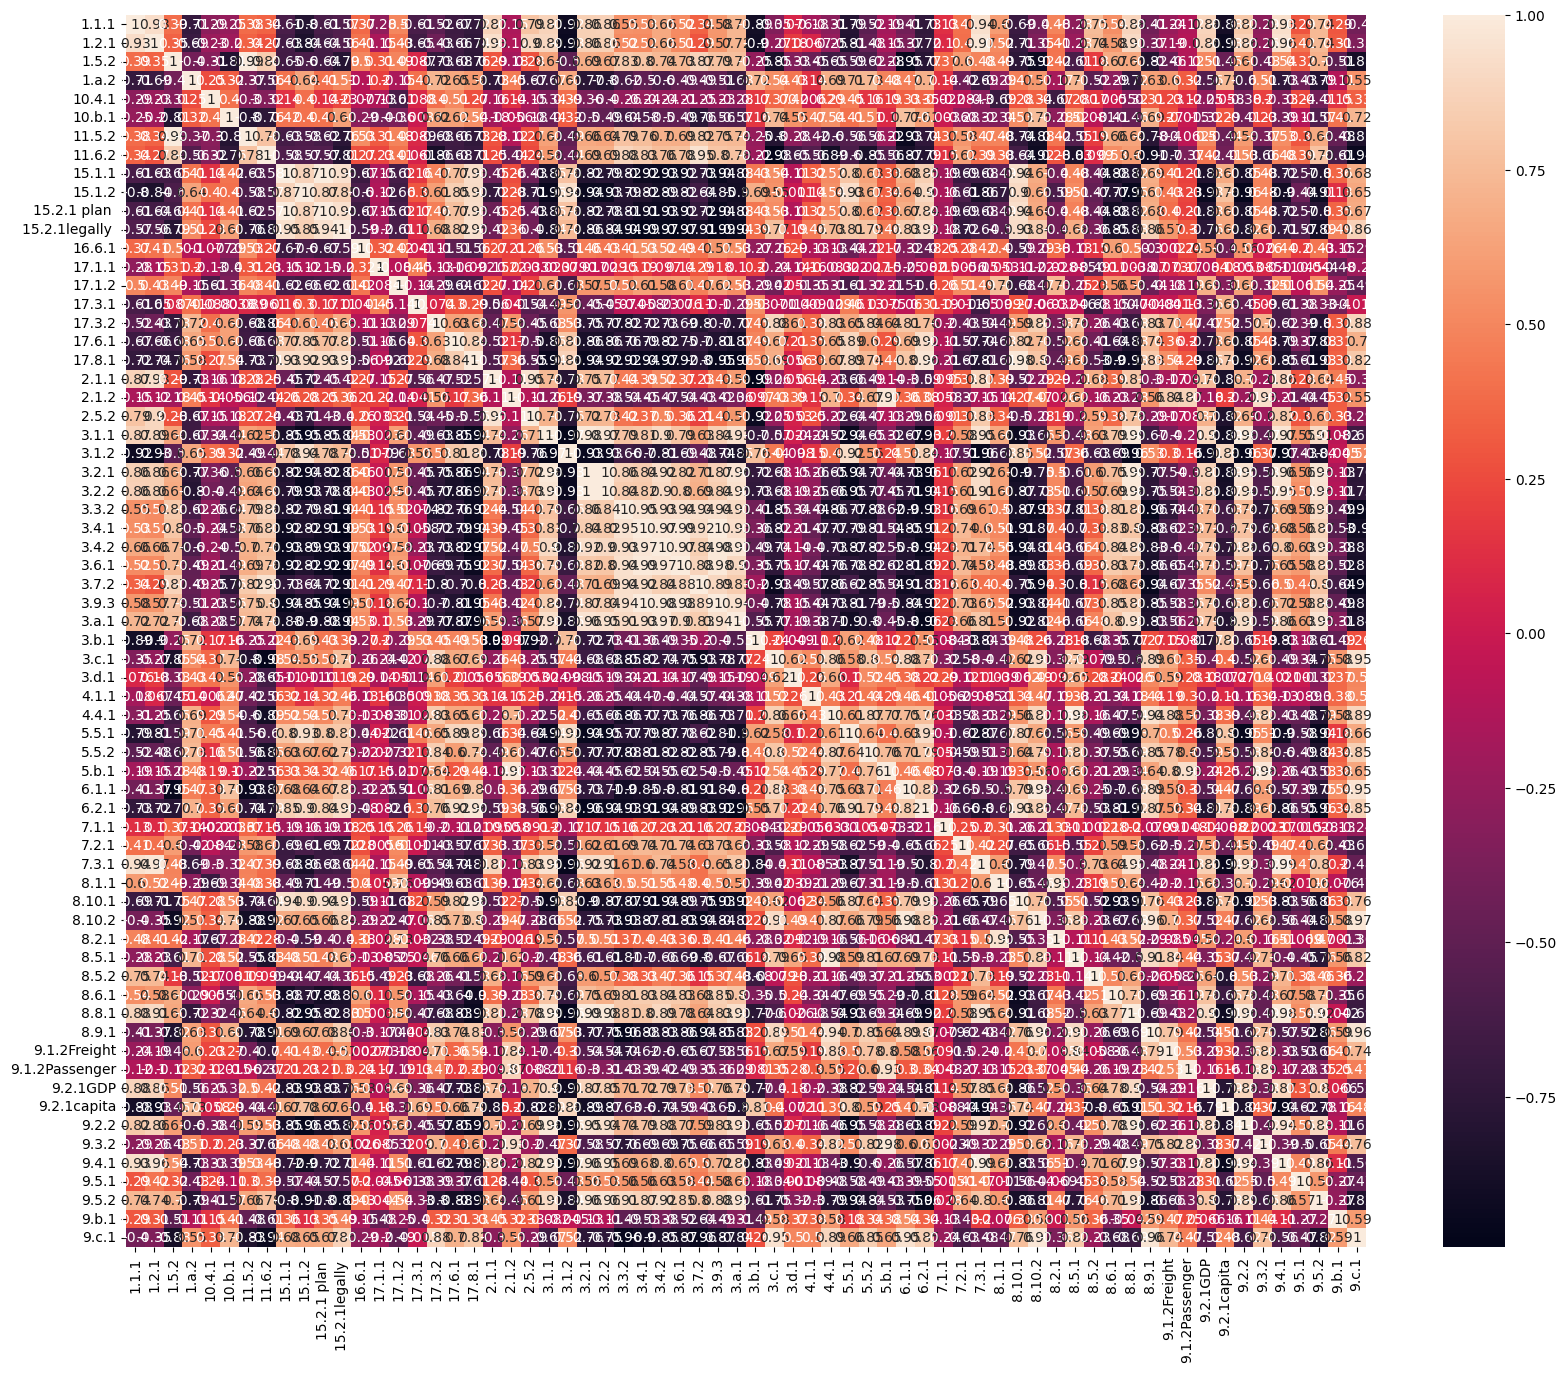

In [6]:
import matplotlib.pyplot as plt

# МАТРИЦА КОРРЕЛЯЦИИ
# Где dfrus - ваш датасет
correlation_matrix = dfrus.corr()

# Выводим признаки на тепловую карту
plt.figure(figsize= (20, 16))
sns.heatmap(correlation_matrix, annot = True)

**Обработка показателей ЦУР по нищите, голоду, качестве образования, достойной работе и экономическго роста. И прогноз на 2021г.**

In [30]:
#Параметры обучения модели
xLen = 5 #Анализируем по 5 прошедшим точкам 
stepsForward = 1            #Тренируем сеть для предсказания на 1 шагов вперед
xChannels =range(11) #Используем все входные каналы
yChannels = range(0,1) #Предсказываем только канал
xNormalization = 1          #Нормируем входные каналы стандартным распределением
yNormalization = 1          #Нормируем выходные каналы стандартным распределением
valLen = 3              #Используем 3 записей для проверки
returnFlatten = False       #Если True, то вернуть одномерные векторы, если False, то двумерные
convertToDerivative = False #Не True, то превращать в производную

#Компилируем модель обучения
modelC=svert1d()
#Save partly trained model
modelC.save('model0.h5')


file_ind = ['1.1.1', '1.2.1', '1.5.2', '1.a.2', '2.1.1', '2.1.2', '2.2.1', '2.2.2', '2.5.2', '4.1.1', '4.4.1', '4.6.1',
            '8.1.1', '8.2.1', '8.3.1', '8.5.1', '8.5.2', '8.6.1', '8.7.1', '8.8.1', '8.9.1', '8.10.1', '8.10.2']
file_pred = pd.DataFrame(file_ind, columns=['Indicator'])

#цикл обучения по параметрам ЦУР
for y_indic in file_ind:
  #Load partly trained model
  modelC = load_model('model0.h5')

  if (~(correlation_matrix.columns.isin([y_indic]).any())):
    continue

  #выборка из корреляционной матрицы параметры значения корреляции которых >0.1 (мало зависимых)
  corr_df = correlation_matrix[y_indic].loc[correlation_matrix[y_indic]>0.1].sort_values(ascending=False)

  #формирование базы по этим параметрам
  Xdfrus = pd.DataFrame(dfrus, columns=corr_df[0:11].index)

  #формирование реестра из 10 наибольших параметров корреляции по параметрам ЦУР
  if dict_corr10_df.empty:
    dict_corr10_df = pd.DataFrame(corr_df[1:11].index, columns=[y_indic])
  else:
    dict_corr10_df[y_indic] = corr_df[1:11].index

  #словарь 10 наибольших параметров корреляции по индикатору
  dict_col_X = pd.Series(Xdfrus.columns, name='Indicator')

  Xdfrus.reset_index(drop=True, inplace=True)
  
  #обучение модели на базах norway, Australia, canada
  name_land = ['norway', 'Australia', 'canada']
  for nl in name_land:
    (modelC, history) = change_learn(nl, modelC)

  #Save partly trained model
  modelC.save(y_indic + '_model0.h5')
  
  Xdfrus = pd.DataFrame(columns=dict_col_X)
  Xdfrus[dict_col_X[dict_col_X.isin(dfrus.columns)]] = dfrus[dict_col_X[dict_col_X.isin(dfrus.columns)]]

  #добавление столбцов для дополнительных индикаторов (один раз)
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest area under a long-term management plan (%)'}, ignore_index=True)
  df_description = df_description.append({'Indicator':'15.2.1legally', 'SeriesDescription':'Proportion of forest area within legally established protected areas (%)'}, ignore_index=True)
  df_description = df_description.append({'Indicator':'9.1.2Freight', 'SeriesDescription':'Freight volume, by mode of transport (tonne kilometres)'}, ignore_index=True)
  df_description = df_description.append({'Indicator':'9.1.2Passenger', 'SeriesDescription':'Passenger volume (passenger kilometres), by mode of transport'}, ignore_index=True)

  #x и y для прогноза
  (xPred, yPred, yScaler)=func_pred(Xdfrus, xChannels, yChannels)
  #прогноз и преобразование в изначальный вид
  predVal = yScaler.inverse_transform(modelC.predict(xPred)) 
  preddf = pd.DataFrame(predVal, columns=['predict'])
  if file_pred.columns.isin(['predict']).any():
    file_pred['predict'].loc[file_pred['Indicator']==y_indic] = preddf['predict'][16]
  else:
    file_pred['predict'] = preddf['predict'][16]
  if file_pred.columns.isin(['MSE']).any():
    file_pred['MSE'].loc[file_pred['Indicator']==y_indic] = history.history['val_loss'][-1]
  else:
    file_pred['MSE'] = history.history['val_loss'][-1]

  

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.34 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 166ms/step - loss: 0.1506 - val_loss: 1.0094
Epoch 2/20
2/2 [==============================] - 0s 31ms/step - loss: 0.1220 - val_loss: 1.0790
Epoch 3/20
2/2 [==============================] - 0s 32ms/step - loss: 0.2540 - val_loss: 1.3113
Epoch 4/20
2/2 [==============================] - 0s 32ms/step - loss: 0.1445 - val_loss: 1.2964
Epoch 5/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0881 - val_loss: 1.2451
Epoch 6/20
2/2 [==============================] - 0s 37ms/step - loss: 0.1274 - val_loss: 1.2812
Epoch 7/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0642 - val_loss: 1.3603
Epoch 8/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0455 - val_loss: 1.4167
Epoch 9/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0806 - val_loss: 1.4290
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.38 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 109ms/step - loss: 0.0809 - val_loss: 0.0699
Epoch 2/20
2/2 [==============================] - 0s 45ms/step - loss: 0.0331 - val_loss: 0.0405
Epoch 3/20
2/2 [==============================] - 0s 59ms/step - loss: 0.0258 - val_loss: 0.0243
Epoch 4/20
2/2 [==============================] - 0s 61ms/step - loss: 0.0477 - val_loss: 0.0157
Epoch 5/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0414 - val_loss: 0.0156
Epoch 6/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0336 - val_loss: 0.0181
Epoch 7/20
2/2 [==============================] - 0s 64ms/step - loss: 0.0220 - val_loss: 0.0192
Epoch 8/20
2/2 [==============================] - 0s 47ms/step - loss: 0.0264 - val_loss: 0.0213
Epoch 9/20
2/2 [==============================] - 0s 43ms/step - loss: 0.0179 - val_loss: 0.0198
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.44 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 104ms/step - loss: 0.0847 - val_loss: 0.0173
Epoch 2/20
2/2 [==============================] - 0s 45ms/step - loss: 0.0813 - val_loss: 0.0010
Epoch 3/20
2/2 [==============================] - 0s 48ms/step - loss: 0.0532 - val_loss: 6.0006e-04
Epoch 4/20
2/2 [==============================] - 0s 71ms/step - loss: 0.0841 - val_loss: 3.8683e-04
Epoch 5/20
2/2 [==============================] - 0s 57ms/step - loss: 0.0235 - val_loss: 2.2954e-04
Epoch 6/20
2/2 [==============================] - 0s 56ms/step - loss: 0.0247 - val_loss: 0.0024
Epoch 7/20
2/2 [==============================] - 0s 45ms/step - loss: 0.0224 - val_loss: 0.0035
Epoch 8/20
2/2 [==============================] - 0s 63ms/step - loss: 0.0274 - val_loss: 0.0025
Epoch 9/20
2/2 [==============================] - 0s 67ms/step - loss: 0.0281 - val_loss: 9.5348e-04
Epoch 10/

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.34 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 173ms/step - loss: 0.0966 - val_loss: 0.0465
Epoch 2/20
2/2 [==============================] - 0s 34ms/step - loss: 0.2518 - val_loss: 0.0024
Epoch 3/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0670 - val_loss: 0.0021
Epoch 4/20
2/2 [==============================] - 0s 32ms/step - loss: 0.2085 - val_loss: 5.0736e-04
Epoch 5/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0781 - val_loss: 0.0089
Epoch 6/20
2/2 [==============================] - 0s 35ms/step - loss: 0.1235 - val_loss: 0.0157
Epoch 7/20
2/2 [==============================] - 0s 53ms/step - loss: 0.0571 - val_loss: 0.0146
Epoch 8/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0855 - val_loss: 0.0094
Epoch 9/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0849 - val_loss: 0.0058
Epoch 10/20
2/2 [====

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.28 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0201

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',


2/2 [==============================] - 0s 108ms/step - loss: 0.0229 - val_loss: 0.0017
Epoch 2/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0226 - val_loss: 0.0021
Epoch 3/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0110 - val_loss: 0.0020
Epoch 4/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0255 - val_loss: 0.0011
Epoch 5/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0150 - val_loss: 7.3501e-04
Epoch 6/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0107 - val_loss: 0.0011
Epoch 7/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0067 - val_loss: 0.0015
Epoch 8/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0070 - val_loss: 0.0020
Epoch 9/20
2/2 [==============================] - 0s 51ms/step - loss: 0.0187 - val_loss: 0.0018
Epoch 10/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0065 - val_loss: 0.0014
Epoch 11/20
2/2 [==================

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.31 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 81ms/step - loss: 0.0279 - val_loss: 0.0042
Epoch 2/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0343 - val_loss: 1.5099e-04
Epoch 3/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0164 - val_loss: 0.0054
Epoch 4/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0368 - val_loss: 0.0063
Epoch 5/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0231 - val_loss: 8.8974e-04
Epoch 6/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0201 - val_loss: 3.1480e-04
Epoch 7/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0166 - val_loss: 4.5965e-04
Epoch 8/20
2/2 [==============================] - 0s 54ms/step - loss: 0.0092 - val_loss: 3.6170e-04
Epoch 9/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0050 - val_loss: 1.1436e-04
Ep

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.35 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 159ms/step - loss: 0.1786 - val_loss: 0.0712
Epoch 2/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0898 - val_loss: 0.0400
Epoch 3/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0951 - val_loss: 0.0443
Epoch 4/20
2/2 [==============================] - 0s 37ms/step - loss: 0.1109 - val_loss: 0.0887
Epoch 5/20
2/2 [==============================] - 0s 45ms/step - loss: 0.0420 - val_loss: 0.1434
Epoch 6/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0346 - val_loss: 0.1627
Epoch 7/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0407 - val_loss: 0.1478
Epoch 8/20
2/2 [==============================] - 0s 51ms/step - loss: 0.0145 - val_loss: 0.1189
Epoch 9/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0286 - val_loss: 0.0962
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.26 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
1/2 [==============>...............] - ETA: 0s - loss: 0.8694

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',


2/2 [==============================] - 0s 104ms/step - loss: 0.8028 - val_loss: 0.5381
Epoch 2/20
2/2 [==============================] - 0s 46ms/step - loss: 0.2201 - val_loss: 0.1811
Epoch 3/20
2/2 [==============================] - 0s 44ms/step - loss: 0.1250 - val_loss: 0.0996
Epoch 4/20
2/2 [==============================] - 0s 55ms/step - loss: 0.3391 - val_loss: 0.1126
Epoch 5/20
2/2 [==============================] - 0s 74ms/step - loss: 0.2888 - val_loss: 0.2165
Epoch 6/20
2/2 [==============================] - 0s 54ms/step - loss: 0.2144 - val_loss: 0.3771
Epoch 7/20
2/2 [==============================] - 0s 50ms/step - loss: 0.1043 - val_loss: 0.5172
Epoch 8/20
2/2 [==============================] - 0s 48ms/step - loss: 0.1212 - val_loss: 0.6145
Epoch 9/20
2/2 [==============================] - 0s 65ms/step - loss: 0.1756 - val_loss: 0.6057
Epoch 10/20
2/2 [==============================] - 0s 72ms/step - loss: 0.0262 - val_loss: 0.5403
Epoch 11/20
2/2 [======================

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.45 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 127ms/step - loss: 0.0304 - val_loss: 0.0581
Epoch 2/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0378 - val_loss: 0.0873
Epoch 3/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0273 - val_loss: 0.1213
Epoch 4/20
2/2 [==============================] - 0s 50ms/step - loss: 0.0330 - val_loss: 0.1236
Epoch 5/20
2/2 [==============================] - 0s 58ms/step - loss: 0.0594 - val_loss: 0.0979
Epoch 6/20
2/2 [==============================] - 0s 47ms/step - loss: 0.0134 - val_loss: 0.0678
Epoch 7/20
2/2 [==============================] - 0s 45ms/step - loss: 0.0207 - val_loss: 0.0515
Epoch 8/20
2/2 [==============================] - 0s 47ms/step - loss: 0.0173 - val_loss: 0.0511
Epoch 9/20
2/2 [==============================] - 0s 45ms/step - loss: 0.0056 - val_loss: 0.0549
Epoch 10/20
2/2 [========

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

1/1 [==============================] - 0s 132ms/step


<ipython-input-30-795400840218>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_pred['predict'].loc[file_pred['Indicator']==y_indic] = preddf['predict'][16]
<ipython-input-30-795400840218>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_pred['MSE'].loc[file_pred['Indicator']==y_indic] = history.history['val_loss'][-1]
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: Fu

Количество загруженных файлов = 15
Затрачено времени - 0.51 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 172ms/step - loss: 0.2043 - val_loss: 0.0322
Epoch 2/20
2/2 [==============================] - 0s 35ms/step - loss: 0.1545 - val_loss: 0.0185
Epoch 3/20
2/2 [==============================] - 0s 34ms/step - loss: 0.1605 - val_loss: 0.0115
Epoch 4/20
2/2 [==============================] - 0s 44ms/step - loss: 0.3450 - val_loss: 0.0581
Epoch 5/20
2/2 [==============================] - 0s 36ms/step - loss: 0.1298 - val_loss: 0.1096
Epoch 6/20
2/2 [==============================] - 0s 33ms/step - loss: 0.1311 - val_loss: 0.0969
Epoch 7/20
2/2 [==============================] - 0s 34ms/step - loss: 0.1276 - val_loss: 0.0270
Epoch 8/20
2/2 [==============================] - 0s 34ms/step - loss: 0.1028 - val_loss: 0.0024
Epoch 9/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0557 - val_loss: 0.0152
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.25 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
1/2 [==============>...............] - ETA: 0s - loss: 0.3169

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',


2/2 [==============================] - 0s 88ms/step - loss: 0.2376 - val_loss: 0.0912
Epoch 2/20
2/2 [==============================] - 0s 35ms/step - loss: 0.1001 - val_loss: 0.0053
Epoch 3/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0940 - val_loss: 0.1351
Epoch 4/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0759 - val_loss: 0.3262
Epoch 5/20
2/2 [==============================] - 0s 31ms/step - loss: 0.0825 - val_loss: 0.4196
Epoch 6/20
2/2 [==============================] - 0s 32ms/step - loss: 0.1123 - val_loss: 0.2745
Epoch 7/20
2/2 [==============================] - 0s 37ms/step - loss: 0.0908 - val_loss: 0.1219
Epoch 8/20
2/2 [==============================] - 0s 37ms/step - loss: 0.0507 - val_loss: 0.0376
Epoch 9/20
2/2 [==============================] - 0s 33ms/step - loss: 0.1029 - val_loss: 0.0102
Epoch 10/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0768 - val_loss: 0.0052
Epoch 11/20
2/2 [=======================

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.31 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 75ms/step - loss: 0.1759 - val_loss: 0.1871
Epoch 2/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0417 - val_loss: 0.0848
Epoch 3/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0592 - val_loss: 0.0506
Epoch 4/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0998 - val_loss: 0.0519
Epoch 5/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0307 - val_loss: 0.0705
Epoch 6/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0366 - val_loss: 0.0849
Epoch 7/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0599 - val_loss: 0.0778
Epoch 8/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0340 - val_loss: 0.0695
Epoch 9/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0243 - val_loss: 0.0598
Epoch 10/20
2/2 [=========

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.34 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 162ms/step - loss: 0.0976 - val_loss: 0.0073
Epoch 2/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0617 - val_loss: 0.0150
Epoch 3/20
2/2 [==============================] - 0s 47ms/step - loss: 0.0984 - val_loss: 0.0094
Epoch 4/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0509 - val_loss: 0.0040
Epoch 5/20
2/2 [==============================] - 0s 37ms/step - loss: 0.0441 - val_loss: 0.0076
Epoch 6/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0327 - val_loss: 0.0169
Epoch 7/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0478 - val_loss: 0.0200
Epoch 8/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0138 - val_loss: 0.0125
Epoch 9/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0218 - val_loss: 0.0022
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.28 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 78ms/step - loss: 0.0054 - val_loss: 6.2981e-04
Epoch 2/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0231 - val_loss: 6.8051e-04
Epoch 3/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0355 - val_loss: 9.1058e-04
Epoch 4/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0231 - val_loss: 0.0011
Epoch 5/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0200 - val_loss: 0.0010
Epoch 6/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0218 - val_loss: 0.0012
Epoch 7/20
2/2 [==============================] - 0s 37ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 8/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0137 - val_loss: 0.0013
Epoch 9/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0147 - val_loss: 0.0015
Epoch 10/20
2/

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.3 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 76ms/step - loss: 0.0196 - val_loss: 0.0037
Epoch 2/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0440 - val_loss: 0.0031
Epoch 3/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0145 - val_loss: 0.0041
Epoch 4/20
2/2 [==============================] - 0s 37ms/step - loss: 0.0301 - val_loss: 0.0066
Epoch 5/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0305 - val_loss: 0.0026
Epoch 6/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0070 - val_loss: 0.0011
Epoch 7/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0049 - val_loss: 8.8429e-04
Epoch 8/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0042 - val_loss: 9.1168e-04
Epoch 9/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0136 - val_loss: 0.0011
Epoch 10/20
2/2 [==

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.52 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 273ms/step - loss: 0.0376 - val_loss: 0.0359
Epoch 2/20
2/2 [==============================] - 0s 66ms/step - loss: 0.0498 - val_loss: 0.0896
Epoch 3/20
2/2 [==============================] - 0s 48ms/step - loss: 0.0873 - val_loss: 0.0273
Epoch 4/20
2/2 [==============================] - 0s 46ms/step - loss: 0.0517 - val_loss: 0.0037
Epoch 5/20
2/2 [==============================] - 0s 46ms/step - loss: 0.0590 - val_loss: 0.0091
Epoch 6/20
2/2 [==============================] - 0s 46ms/step - loss: 0.0156 - val_loss: 0.0258
Epoch 7/20
2/2 [==============================] - 0s 54ms/step - loss: 0.0336 - val_loss: 0.0338
Epoch 8/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0529 - val_loss: 0.0257
Epoch 9/20
2/2 [==============================] - 0s 46ms/step - loss: 0.0234 - val_loss: 0.0149
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.38 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 130ms/step - loss: 0.0136 - val_loss: 0.5137
Epoch 2/20
2/2 [==============================] - 0s 81ms/step - loss: 0.0100 - val_loss: 0.5078
Epoch 3/20
2/2 [==============================] - 0s 45ms/step - loss: 0.0039 - val_loss: 0.4824
Epoch 4/20
2/2 [==============================] - 0s 53ms/step - loss: 0.0186 - val_loss: 0.5395
Epoch 5/20
2/2 [==============================] - 0s 45ms/step - loss: 0.0044 - val_loss: 0.5720
Epoch 6/20
2/2 [==============================] - 0s 48ms/step - loss: 0.0135 - val_loss: 0.5086
Epoch 7/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0124 - val_loss: 0.5050
Epoch 8/20
2/2 [==============================] - 0s 55ms/step - loss: 0.0022 - val_loss: 0.5582
Epoch 9/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0075 - val_loss: 0.5581
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.31 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 82ms/step - loss: 0.0097 - val_loss: 0.6453
Epoch 2/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0113 - val_loss: 0.6737
Epoch 3/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0081 - val_loss: 0.7429
Epoch 4/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0071 - val_loss: 0.7343
Epoch 5/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0047 - val_loss: 0.7095
Epoch 6/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0074 - val_loss: 0.6780
Epoch 7/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0079 - val_loss: 0.6499
Epoch 8/20
2/2 [==============================] - 0s 49ms/step - loss: 0.0012 - val_loss: 0.6454
Epoch 9/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0069 - val_loss: 0.6621
Epoch 10/20
2/2 [=========

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.37 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 170ms/step - loss: 0.4719 - val_loss: 0.1898
Epoch 2/20
2/2 [==============================] - 0s 37ms/step - loss: 0.1315 - val_loss: 0.1140
Epoch 3/20
2/2 [==============================] - 0s 35ms/step - loss: 0.3011 - val_loss: 0.1474
Epoch 4/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0492 - val_loss: 0.2181
Epoch 5/20
2/2 [==============================] - 0s 34ms/step - loss: 0.1244 - val_loss: 0.2875
Epoch 6/20
2/2 [==============================] - 0s 37ms/step - loss: 0.1240 - val_loss: 0.3323
Epoch 7/20
2/2 [==============================] - 0s 35ms/step - loss: 0.1611 - val_loss: 0.3263
Epoch 8/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0302 - val_loss: 0.3134
Epoch 9/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0787 - val_loss: 0.3310
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.27 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
1/2 [==============>...............] - ETA: 0s - loss: 0.5376

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',


2/2 [==============================] - 0s 85ms/step - loss: 0.4918 - val_loss: 0.3066
Epoch 2/20
2/2 [==============================] - 0s 36ms/step - loss: 0.2263 - val_loss: 0.1926
Epoch 3/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0304 - val_loss: 0.1314
Epoch 4/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0752 - val_loss: 0.1119
Epoch 5/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0910 - val_loss: 0.1095
Epoch 6/20
2/2 [==============================] - 0s 51ms/step - loss: 0.0554 - val_loss: 0.1162
Epoch 7/20
2/2 [==============================] - 0s 43ms/step - loss: 0.0305 - val_loss: 0.1314
Epoch 8/20
2/2 [==============================] - 0s 52ms/step - loss: 0.0110 - val_loss: 0.1463
Epoch 9/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0206 - val_loss: 0.1585
Epoch 10/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0318 - val_loss: 0.1649
Epoch 11/20
2/2 [=======================

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.32 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 75ms/step - loss: 0.2157 - val_loss: 0.0049
Epoch 2/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0632 - val_loss: 0.0305
Epoch 3/20
2/2 [==============================] - 0s 35ms/step - loss: 0.1330 - val_loss: 0.0604
Epoch 4/20
2/2 [==============================] - 0s 34ms/step - loss: 0.1873 - val_loss: 0.0166
Epoch 5/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0677 - val_loss: 0.0049
Epoch 6/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0682 - val_loss: 0.0080
Epoch 7/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0401 - val_loss: 0.0075
Epoch 8/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0186 - val_loss: 0.0044
Epoch 9/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0712 - val_loss: 0.0063
Epoch 10/20
2/2 [=========

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.35 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 176ms/step - loss: 0.5896 - val_loss: 0.0065
Epoch 2/20
2/2 [==============================] - 0s 45ms/step - loss: 0.1164 - val_loss: 0.0797
Epoch 3/20
2/2 [==============================] - 0s 35ms/step - loss: 0.3362 - val_loss: 0.0083
Epoch 4/20
2/2 [==============================] - 0s 35ms/step - loss: 0.1097 - val_loss: 0.0293
Epoch 5/20
2/2 [==============================] - 0s 35ms/step - loss: 0.1373 - val_loss: 0.0633
Epoch 6/20
2/2 [==============================] - 0s 41ms/step - loss: 0.3156 - val_loss: 0.0582
Epoch 7/20
2/2 [==============================] - 0s 34ms/step - loss: 0.1057 - val_loss: 0.0270
Epoch 8/20
2/2 [==============================] - 0s 49ms/step - loss: 0.0605 - val_loss: 0.0132
Epoch 9/20
2/2 [==============================] - 0s 56ms/step - loss: 0.1105 - val_loss: 0.0085
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 1.4 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 129ms/step - loss: 0.2571 - val_loss: 0.0668
Epoch 2/20
2/2 [==============================] - 0s 99ms/step - loss: 0.1248 - val_loss: 0.2234
Epoch 3/20
2/2 [==============================] - 0s 58ms/step - loss: 0.1234 - val_loss: 0.5102
Epoch 4/20
2/2 [==============================] - 0s 81ms/step - loss: 0.0703 - val_loss: 0.7195
Epoch 5/20
2/2 [==============================] - 0s 85ms/step - loss: 0.0756 - val_loss: 0.7586
Epoch 6/20
2/2 [==============================] - 0s 80ms/step - loss: 0.1154 - val_loss: 0.6236
Epoch 7/20
2/2 [==============================] - 0s 62ms/step - loss: 0.1128 - val_loss: 0.3850
Epoch 8/20
2/2 [==============================] - 0s 66ms/step - loss: 0.0170 - val_loss: 0.2656
Epoch 9/20
2/2 [==============================] - 0s 86ms/step - loss: 0.0946 - val_loss: 0.2072
Epoch 10/20
2/2 [=========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.32 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 93ms/step - loss: 0.0427 - val_loss: 0.3583
Epoch 2/20
2/2 [==============================] - 0s 47ms/step - loss: 0.0802 - val_loss: 0.3786
Epoch 3/20
2/2 [==============================] - 0s 52ms/step - loss: 0.0588 - val_loss: 0.3788
Epoch 4/20
2/2 [==============================] - 0s 46ms/step - loss: 0.1053 - val_loss: 0.3452
Epoch 5/20
2/2 [==============================] - 0s 51ms/step - loss: 0.0593 - val_loss: 0.3143
Epoch 6/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0262 - val_loss: 0.2967
Epoch 7/20
2/2 [==============================] - 0s 53ms/step - loss: 0.0163 - val_loss: 0.2861
Epoch 8/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0258 - val_loss: 0.2695
Epoch 9/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0301 - val_loss: 0.2753
Epoch 10/20
2/2 [=========

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.37 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 200ms/step - loss: 1.0996 - val_loss: 0.0717
Epoch 2/20
2/2 [==============================] - 0s 45ms/step - loss: 0.0583 - val_loss: 0.3386
Epoch 3/20
2/2 [==============================] - 0s 41ms/step - loss: 1.0021 - val_loss: 0.2480
Epoch 4/20
2/2 [==============================] - 0s 42ms/step - loss: 0.2964 - val_loss: 0.1052
Epoch 5/20
2/2 [==============================] - 0s 43ms/step - loss: 0.0321 - val_loss: 0.0660
Epoch 6/20
2/2 [==============================] - 0s 43ms/step - loss: 0.0651 - val_loss: 0.0687
Epoch 7/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0863 - val_loss: 0.0737
Epoch 8/20
2/2 [==============================] - 0s 40ms/step - loss: 0.1555 - val_loss: 0.0671
Epoch 9/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0766 - val_loss: 0.0619
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.27 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 88ms/step - loss: 0.1902 - val_loss: 0.0208
Epoch 2/20
2/2 [==============================] - 0s 43ms/step - loss: 0.0444 - val_loss: 0.0131
Epoch 3/20
2/2 [==============================] - 0s 45ms/step - loss: 0.0180 - val_loss: 0.0487
Epoch 4/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0187 - val_loss: 0.0650
Epoch 5/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0345 - val_loss: 0.0462
Epoch 6/20
2/2 [==============================] - 0s 43ms/step - loss: 0.0146 - val_loss: 0.0208
Epoch 7/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0212 - val_loss: 0.0050
Epoch 8/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0094 - val_loss: 0.0072
Epoch 9/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0159 - val_loss: 0.0172
Epoch 10/20
2/2 [=========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.31 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 100ms/step - loss: 0.1007 - val_loss: 0.1365
Epoch 2/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0421 - val_loss: 0.0590
Epoch 3/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0273 - val_loss: 0.0223
Epoch 4/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0516 - val_loss: 0.0173
Epoch 5/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0442 - val_loss: 0.0317
Epoch 6/20
2/2 [==============================] - 0s 51ms/step - loss: 0.0297 - val_loss: 0.0642
Epoch 7/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0165 - val_loss: 0.1107
Epoch 8/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0131 - val_loss: 0.1468
Epoch 9/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0117 - val_loss: 0.1596
Epoch 10/20
2/2 [========

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.52 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 300ms/step - loss: 0.4946 - val_loss: 0.1037
Epoch 2/20
2/2 [==============================] - 0s 88ms/step - loss: 0.2737 - val_loss: 0.0784
Epoch 3/20
2/2 [==============================] - 0s 70ms/step - loss: 0.0840 - val_loss: 0.1240
Epoch 4/20
2/2 [==============================] - 0s 67ms/step - loss: 0.0364 - val_loss: 0.1964
Epoch 5/20
2/2 [==============================] - 0s 75ms/step - loss: 0.1295 - val_loss: 0.2349
Epoch 6/20
2/2 [==============================] - 0s 68ms/step - loss: 0.2184 - val_loss: 0.1972
Epoch 7/20
2/2 [==============================] - 0s 48ms/step - loss: 0.1115 - val_loss: 0.1534
Epoch 8/20
2/2 [==============================] - 0s 66ms/step - loss: 0.0855 - val_loss: 0.1620
Epoch 9/20
2/2 [==============================] - 0s 56ms/step - loss: 0.2486 - val_loss: 0.1634
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.27 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
1/2 [==============>...............] - ETA: 0s - loss: 0.2023

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',


2/2 [==============================] - 0s 92ms/step - loss: 0.2391 - val_loss: 0.0966
Epoch 2/20
2/2 [==============================] - 0s 36ms/step - loss: 0.1144 - val_loss: 0.1277
Epoch 3/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0781 - val_loss: 0.1622
Epoch 4/20
2/2 [==============================] - 0s 42ms/step - loss: 0.1485 - val_loss: 0.1532
Epoch 5/20
2/2 [==============================] - 0s 42ms/step - loss: 0.1147 - val_loss: 0.1317
Epoch 6/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0692 - val_loss: 0.1108
Epoch 7/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0254 - val_loss: 0.0982
Epoch 8/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0725 - val_loss: 0.0946
Epoch 9/20
2/2 [==============================] - 0s 43ms/step - loss: 0.1208 - val_loss: 0.1022
Epoch 10/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0755 - val_loss: 0.1198
Epoch 11/20
2/2 [=======================

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.32 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 83ms/step - loss: 0.1019 - val_loss: 0.2866
Epoch 2/20
2/2 [==============================] - 0s 38ms/step - loss: 0.1013 - val_loss: 0.2502
Epoch 3/20
2/2 [==============================] - 0s 40ms/step - loss: 0.1378 - val_loss: 0.2439
Epoch 4/20
2/2 [==============================] - 0s 46ms/step - loss: 0.0416 - val_loss: 0.2311
Epoch 5/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0553 - val_loss: 0.2154
Epoch 6/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0596 - val_loss: 0.2069
Epoch 7/20
2/2 [==============================] - 0s 39ms/step - loss: 0.1158 - val_loss: 0.1930
Epoch 8/20
2/2 [==============================] - 0s 36ms/step - loss: 0.1042 - val_loss: 0.1936
Epoch 9/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0747 - val_loss: 0.2134
Epoch 10/20
2/2 [=========

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.36 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 178ms/step - loss: 0.5293 - val_loss: 0.0253
Epoch 2/20
2/2 [==============================] - 0s 39ms/step - loss: 0.3747 - val_loss: 0.0168
Epoch 3/20
2/2 [==============================] - 0s 48ms/step - loss: 0.5246 - val_loss: 0.0424
Epoch 4/20
2/2 [==============================] - 0s 38ms/step - loss: 0.1733 - val_loss: 0.1317
Epoch 5/20
2/2 [==============================] - 0s 44ms/step - loss: 0.1131 - val_loss: 0.2267
Epoch 6/20
2/2 [==============================] - 0s 41ms/step - loss: 0.2716 - val_loss: 0.2498
Epoch 7/20
2/2 [==============================] - 0s 48ms/step - loss: 0.1677 - val_loss: 0.2286
Epoch 8/20
2/2 [==============================] - 0s 42ms/step - loss: 0.1456 - val_loss: 0.1782
Epoch 9/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0999 - val_loss: 0.1267
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.29 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0850

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',


2/2 [==============================] - 0s 85ms/step - loss: 0.1761 - val_loss: 0.0138
Epoch 2/20
2/2 [==============================] - 0s 59ms/step - loss: 0.0683 - val_loss: 0.0073
Epoch 3/20
2/2 [==============================] - 0s 39ms/step - loss: 0.1446 - val_loss: 0.0086
Epoch 4/20
2/2 [==============================] - 0s 36ms/step - loss: 0.1985 - val_loss: 0.0077
Epoch 5/20
2/2 [==============================] - 0s 38ms/step - loss: 0.1678 - val_loss: 0.0059
Epoch 6/20
2/2 [==============================] - 0s 41ms/step - loss: 0.1289 - val_loss: 0.0078
Epoch 7/20
2/2 [==============================] - 0s 38ms/step - loss: 0.1413 - val_loss: 0.0150
Epoch 8/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0960 - val_loss: 0.0240
Epoch 9/20
2/2 [==============================] - 0s 39ms/step - loss: 0.1234 - val_loss: 0.0257
Epoch 10/20
2/2 [==============================] - 0s 38ms/step - loss: 0.1224 - val_loss: 0.0227
Epoch 11/20
2/2 [=======================

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.31 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 84ms/step - loss: 0.0854 - val_loss: 0.0502
Epoch 2/20
2/2 [==============================] - 0s 36ms/step - loss: 0.1040 - val_loss: 0.0887
Epoch 3/20
2/2 [==============================] - 0s 36ms/step - loss: 0.1396 - val_loss: 0.1482
Epoch 4/20
2/2 [==============================] - 0s 35ms/step - loss: 0.1301 - val_loss: 0.1981
Epoch 5/20
2/2 [==============================] - 0s 38ms/step - loss: 0.1170 - val_loss: 0.1971
Epoch 6/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0706 - val_loss: 0.1683
Epoch 7/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0333 - val_loss: 0.1481
Epoch 8/20
2/2 [==============================] - 0s 37ms/step - loss: 0.1110 - val_loss: 0.1362
Epoch 9/20
2/2 [==============================] - 0s 37ms/step - loss: 0.0991 - val_loss: 0.1327
Epoch 10/20
2/2 [=========

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.47 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 262ms/step - loss: 0.0413 - val_loss: 1.5074
Epoch 2/20
2/2 [==============================] - 0s 49ms/step - loss: 0.0605 - val_loss: 1.2778
Epoch 3/20
2/2 [==============================] - 0s 50ms/step - loss: 0.0538 - val_loss: 1.4121
Epoch 4/20
2/2 [==============================] - 0s 48ms/step - loss: 0.0647 - val_loss: 1.3771
Epoch 5/20
2/2 [==============================] - 0s 63ms/step - loss: 0.0396 - val_loss: 1.0766
Epoch 6/20
2/2 [==============================] - 0s 63ms/step - loss: 0.0430 - val_loss: 1.0122
Epoch 7/20
2/2 [==============================] - 0s 62ms/step - loss: 0.0288 - val_loss: 1.1226
Epoch 8/20
2/2 [==============================] - 0s 54ms/step - loss: 0.0193 - val_loss: 1.3078
Epoch 9/20
2/2 [==============================] - 0s 52ms/step - loss: 0.0393 - val_loss: 1.3906
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.38 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 119ms/step - loss: 0.0064 - val_loss: 0.0026
Epoch 2/20
2/2 [==============================] - 0s 47ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 3/20
2/2 [==============================] - 0s 49ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 4/20
2/2 [==============================] - 0s 57ms/step - loss: 0.0250 - val_loss: 0.0045
Epoch 5/20
2/2 [==============================] - 0s 64ms/step - loss: 0.0074 - val_loss: 0.0334
Epoch 6/20
2/2 [==============================] - 0s 89ms/step - loss: 0.0382 - val_loss: 0.0239
Epoch 7/20
2/2 [==============================] - 0s 61ms/step - loss: 0.0099 - val_loss: 0.0050
Epoch 8/20
2/2 [==============================] - 0s 65ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 9/20
2/2 [==============================] - 0s 73ms/step - loss: 0.0156 - val_loss: 0.0057
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.33 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 99ms/step - loss: 0.0192 - val_loss: 0.0109
Epoch 2/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0188 - val_loss: 0.0089
Epoch 3/20
2/2 [==============================] - 0s 43ms/step - loss: 0.0214 - val_loss: 0.0101
Epoch 4/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0116 - val_loss: 0.0068
Epoch 5/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0106 - val_loss: 0.0146
Epoch 6/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0119 - val_loss: 0.0249
Epoch 7/20
2/2 [==============================] - 0s 37ms/step - loss: 0.0088 - val_loss: 0.0247
Epoch 8/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0101 - val_loss: 0.0148
Epoch 9/20
2/2 [==============================] - 0s 43ms/step - loss: 0.0036 - val_loss: 0.0054
Epoch 10/20
2/2 [=========

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.36 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 161ms/step - loss: 0.3407 - val_loss: 0.1010
Epoch 2/20
2/2 [==============================] - 0s 44ms/step - loss: 0.1361 - val_loss: 0.1004
Epoch 3/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0092 - val_loss: 0.1254
Epoch 4/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0796 - val_loss: 0.1576
Epoch 5/20
2/2 [==============================] - 0s 46ms/step - loss: 0.0859 - val_loss: 0.1358
Epoch 6/20
2/2 [==============================] - 0s 49ms/step - loss: 0.0771 - val_loss: 0.1034
Epoch 7/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0656 - val_loss: 0.0989
Epoch 8/20
2/2 [==============================] - 0s 45ms/step - loss: 0.0224 - val_loss: 0.0996
Epoch 9/20
2/2 [==============================] - 0s 37ms/step - loss: 0.0568 - val_loss: 0.1067
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.27 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
1/2 [==============>...............] - ETA: 0s - loss: 0.0807

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',


2/2 [==============================] - 0s 91ms/step - loss: 0.0727 - val_loss: 0.0711
Epoch 2/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0645 - val_loss: 0.0518
Epoch 3/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0406 - val_loss: 0.0413
Epoch 4/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0307 - val_loss: 0.0380
Epoch 5/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0618 - val_loss: 0.0490
Epoch 6/20
2/2 [==============================] - 0s 50ms/step - loss: 0.0348 - val_loss: 0.0653
Epoch 7/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0306 - val_loss: 0.0831
Epoch 8/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0671 - val_loss: 0.1063
Epoch 9/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0289 - val_loss: 0.1190
Epoch 10/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0626 - val_loss: 0.1323
Epoch 11/20
2/2 [=======================

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.33 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 84ms/step - loss: 0.8070 - val_loss: 0.1220
Epoch 2/20
2/2 [==============================] - 0s 37ms/step - loss: 0.2355 - val_loss: 0.0080
Epoch 3/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0241 - val_loss: 0.0335
Epoch 4/20
2/2 [==============================] - 0s 45ms/step - loss: 0.1252 - val_loss: 0.0791
Epoch 5/20
2/2 [==============================] - 0s 46ms/step - loss: 0.2513 - val_loss: 0.0844
Epoch 6/20
2/2 [==============================] - 0s 35ms/step - loss: 0.2216 - val_loss: 0.0528
Epoch 7/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0354 - val_loss: 0.0266
Epoch 8/20
2/2 [==============================] - 0s 37ms/step - loss: 0.0285 - val_loss: 0.0111
Epoch 9/20
2/2 [==============================] - 0s 46ms/step - loss: 0.0468 - val_loss: 0.0041
Epoch 10/20
2/2 [=========

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.37 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 172ms/step - loss: 0.6848 - val_loss: 0.0191
Epoch 2/20
2/2 [==============================] - 0s 44ms/step - loss: 0.4598 - val_loss: 0.0313
Epoch 3/20
2/2 [==============================] - 0s 41ms/step - loss: 0.2770 - val_loss: 0.1033
Epoch 4/20
2/2 [==============================] - 0s 37ms/step - loss: 0.0734 - val_loss: 0.1993
Epoch 5/20
2/2 [==============================] - 0s 36ms/step - loss: 0.3279 - val_loss: 0.2087
Epoch 6/20
2/2 [==============================] - 0s 38ms/step - loss: 0.2888 - val_loss: 0.1429
Epoch 7/20
2/2 [==============================] - 0s 42ms/step - loss: 0.1952 - val_loss: 0.0783
Epoch 8/20
2/2 [==============================] - 0s 38ms/step - loss: 0.1407 - val_loss: 0.0365
Epoch 9/20
2/2 [==============================] - 0s 41ms/step - loss: 0.2262 - val_loss: 0.0240
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.27 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 121ms/step - loss: 0.6119 - val_loss: 8.5270e-04
Epoch 2/20
2/2 [==============================] - 0s 55ms/step - loss: 0.4627 - val_loss: 0.0433
Epoch 3/20
2/2 [==============================] - 0s 50ms/step - loss: 0.0381 - val_loss: 0.1433
Epoch 4/20
2/2 [==============================] - 0s 83ms/step - loss: 0.0936 - val_loss: 0.2363
Epoch 5/20
2/2 [==============================] - 0s 55ms/step - loss: 0.2733 - val_loss: 0.2484
Epoch 6/20
2/2 [==============================] - 0s 80ms/step - loss: 0.1842 - val_loss: 0.2032
Epoch 7/20
2/2 [==============================] - 0s 92ms/step - loss: 0.1270 - val_loss: 0.1409
Epoch 8/20
2/2 [==============================] - 0s 77ms/step - loss: 0.0762 - val_loss: 0.1007
Epoch 9/20
2/2 [==============================] - 0s 79ms/step - loss: 0.0636 - val_loss: 0.0856
Epoch 10/20
2/2 [====

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.45 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 124ms/step - loss: 0.0863 - val_loss: 0.0010
Epoch 2/20
2/2 [==============================] - 0s 53ms/step - loss: 0.0452 - val_loss: 8.5605e-04
Epoch 3/20
2/2 [==============================] - 0s 46ms/step - loss: 0.0124 - val_loss: 0.0029
Epoch 4/20
2/2 [==============================] - 0s 67ms/step - loss: 0.0438 - val_loss: 0.0042
Epoch 5/20
2/2 [==============================] - 0s 50ms/step - loss: 0.0679 - val_loss: 0.0022
Epoch 6/20
2/2 [==============================] - 0s 69ms/step - loss: 0.0290 - val_loss: 4.8184e-04
Epoch 7/20
2/2 [==============================] - 0s 69ms/step - loss: 0.0271 - val_loss: 2.7767e-04
Epoch 8/20
2/2 [==============================] - 0s 72ms/step - loss: 0.0629 - val_loss: 3.8455e-04
Epoch 9/20
2/2 [==============================] - 0s 47ms/step - loss: 0.0367 - val_loss: 1.6709e-04
Epoch

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.36 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 169ms/step - loss: 0.2355 - val_loss: 0.0685
Epoch 2/20
2/2 [==============================] - 0s 42ms/step - loss: 0.2045 - val_loss: 0.1077
Epoch 3/20
2/2 [==============================] - 0s 39ms/step - loss: 0.1014 - val_loss: 0.0956
Epoch 4/20
2/2 [==============================] - 0s 35ms/step - loss: 0.1940 - val_loss: 0.0593
Epoch 5/20
2/2 [==============================] - 0s 42ms/step - loss: 0.1583 - val_loss: 0.0660
Epoch 6/20
2/2 [==============================] - 0s 38ms/step - loss: 0.1952 - val_loss: 0.1106
Epoch 7/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0702 - val_loss: 0.1325
Epoch 8/20
2/2 [==============================] - 0s 49ms/step - loss: 0.1151 - val_loss: 0.1340
Epoch 9/20
2/2 [==============================] - 0s 37ms/step - loss: 0.0378 - val_loss: 0.1158
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.28 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
1/2 [==============>...............] - ETA: 0s - loss: 0.1253

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',


2/2 [==============================] - 0s 98ms/step - loss: 0.0995 - val_loss: 0.2536
Epoch 2/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0544 - val_loss: 0.3664
Epoch 3/20
2/2 [==============================] - 0s 53ms/step - loss: 0.0431 - val_loss: 0.5070
Epoch 4/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0503 - val_loss: 0.5594
Epoch 5/20
2/2 [==============================] - 0s 37ms/step - loss: 0.0067 - val_loss: 0.5702
Epoch 6/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0281 - val_loss: 0.6035
Epoch 7/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0318 - val_loss: 0.6325
Epoch 8/20
2/2 [==============================] - 0s 57ms/step - loss: 0.0068 - val_loss: 0.6375
Epoch 9/20
2/2 [==============================] - 0s 43ms/step - loss: 0.0360 - val_loss: 0.6738
Epoch 10/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0388 - val_loss: 0.7103
Epoch 11/20
2/2 [=======================

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.31 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 90ms/step - loss: 0.0116 - val_loss: 0.0059
Epoch 2/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0324 - val_loss: 0.0016
Epoch 3/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0133 - val_loss: 8.6434e-04
Epoch 4/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0156 - val_loss: 0.0031
Epoch 5/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0389 - val_loss: 0.0038
Epoch 6/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0284 - val_loss: 0.0019
Epoch 7/20
2/2 [==============================] - 0s 47ms/step - loss: 0.0098 - val_loss: 0.0012
Epoch 8/20
2/2 [==============================] - 0s 37ms/step - loss: 0.0113 - val_loss: 0.0015
Epoch 9/20
2/2 [==============================] - 0s 47ms/step - loss: 0.0145 - val_loss: 6.4826e-04
Epoch 10/20
2/2 [=

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.66 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 158ms/step - loss: 0.2819 - val_loss: 0.5533
Epoch 2/20
2/2 [==============================] - 0s 39ms/step - loss: 0.2082 - val_loss: 0.4079
Epoch 3/20
2/2 [==============================] - 0s 34ms/step - loss: 0.1807 - val_loss: 0.8150
Epoch 4/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0249 - val_loss: 1.2066
Epoch 5/20
2/2 [==============================] - 0s 46ms/step - loss: 0.1839 - val_loss: 1.1926
Epoch 6/20
2/2 [==============================] - 0s 40ms/step - loss: 0.1782 - val_loss: 0.8590
Epoch 7/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0621 - val_loss: 0.5625
Epoch 8/20
2/2 [==============================] - 0s 36ms/step - loss: 0.1276 - val_loss: 0.5201
Epoch 9/20
2/2 [==============================] - 0s 40ms/step - loss: 0.1394 - val_loss: 0.6194
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.37 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 106ms/step - loss: 0.0997 - val_loss: 0.5480
Epoch 2/20
2/2 [==============================] - 0s 48ms/step - loss: 0.0798 - val_loss: 0.4007
Epoch 3/20
2/2 [==============================] - 0s 57ms/step - loss: 0.0344 - val_loss: 0.2996
Epoch 4/20
2/2 [==============================] - 0s 76ms/step - loss: 0.1033 - val_loss: 0.3036
Epoch 5/20
2/2 [==============================] - 0s 56ms/step - loss: 0.0470 - val_loss: 0.3748
Epoch 6/20
2/2 [==============================] - 0s 70ms/step - loss: 0.0248 - val_loss: 0.4551
Epoch 7/20
2/2 [==============================] - 0s 77ms/step - loss: 0.0253 - val_loss: 0.5195
Epoch 8/20
2/2 [==============================] - 0s 47ms/step - loss: 0.0287 - val_loss: 0.5918
Epoch 9/20
2/2 [==============================] - 0s 57ms/step - loss: 0.0243 - val_loss: 0.6347
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.32 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 82ms/step - loss: 0.0610 - val_loss: 8.6398e-04
Epoch 2/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0891 - val_loss: 0.0072
Epoch 3/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0380 - val_loss: 0.0169
Epoch 4/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0850 - val_loss: 0.0091
Epoch 5/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0558 - val_loss: 0.0010
Epoch 6/20
2/2 [==============================] - 0s 37ms/step - loss: 0.0273 - val_loss: 0.0057
Epoch 7/20
2/2 [==============================] - 0s 49ms/step - loss: 0.0297 - val_loss: 0.0134
Epoch 8/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0456 - val_loss: 0.0130
Epoch 9/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0059 - val_loss: 0.0104
Epoch 10/20
2/2 [=====

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.34 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 181ms/step - loss: 0.7258 - val_loss: 0.2562
Epoch 2/20
2/2 [==============================] - 0s 43ms/step - loss: 0.1205 - val_loss: 0.7054
Epoch 3/20
2/2 [==============================] - 0s 41ms/step - loss: 0.3749 - val_loss: 0.4515
Epoch 4/20
2/2 [==============================] - 0s 65ms/step - loss: 0.1690 - val_loss: 0.1379
Epoch 5/20
2/2 [==============================] - 0s 43ms/step - loss: 0.1581 - val_loss: 0.0283
Epoch 6/20
2/2 [==============================] - 0s 47ms/step - loss: 0.0550 - val_loss: 0.0029
Epoch 7/20
2/2 [==============================] - 0s 42ms/step - loss: 0.2328 - val_loss: 0.0028
Epoch 8/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0328 - val_loss: 0.0096
Epoch 9/20
2/2 [==============================] - 0s 46ms/step - loss: 0.0515 - val_loss: 0.0231
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.28 cек
Convert Pandas.Series to Numpy array
Epoch 1/20


<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',


2/2 [==============================] - 0s 81ms/step - loss: 0.2294 - val_loss: 0.3298
Epoch 2/20
2/2 [==============================] - 0s 41ms/step - loss: 0.2256 - val_loss: 0.5608
Epoch 3/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0742 - val_loss: 0.9257
Epoch 4/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0740 - val_loss: 1.3991
Epoch 5/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0355 - val_loss: 1.8058
Epoch 6/20
2/2 [==============================] - 0s 43ms/step - loss: 0.0731 - val_loss: 2.0267
Epoch 7/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0494 - val_loss: 2.0480
Epoch 8/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0604 - val_loss: 1.8304
Epoch 9/20
2/2 [==============================] - 0s 49ms/step - loss: 0.0237 - val_loss: 1.6180
Epoch 10/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0326 - val_loss: 1.3991
Epoch 11/20
2/2 [=======================

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.33 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 79ms/step - loss: 0.1153 - val_loss: 0.1515
Epoch 2/20
2/2 [==============================] - 0s 50ms/step - loss: 0.0955 - val_loss: 0.0820
Epoch 3/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0191 - val_loss: 0.0478
Epoch 4/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0944 - val_loss: 0.0358
Epoch 5/20
2/2 [==============================] - 0s 38ms/step - loss: 0.0465 - val_loss: 0.0326
Epoch 6/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0790 - val_loss: 0.0305
Epoch 7/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0407 - val_loss: 0.0347
Epoch 8/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0316 - val_loss: 0.0342
Epoch 9/20
2/2 [==============================] - 0s 44ms/step - loss: 0.0453 - val_loss: 0.0235
Epoch 10/20
2/2 [=========

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

Количество загруженных файлов = 15
Затрачено времени - 0.35 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 1s 173ms/step - loss: 1.1297 - val_loss: 0.3194
Epoch 2/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0811 - val_loss: 0.9828
Epoch 3/20
2/2 [==============================] - 0s 54ms/step - loss: 0.3456 - val_loss: 0.9668
Epoch 4/20
2/2 [==============================] - 0s 73ms/step - loss: 0.2995 - val_loss: 0.6689
Epoch 5/20
2/2 [==============================] - 0s 65ms/step - loss: 0.2074 - val_loss: 0.3498
Epoch 6/20
2/2 [==============================] - 0s 71ms/step - loss: 0.1187 - val_loss: 0.2175
Epoch 7/20
2/2 [==============================] - 0s 79ms/step - loss: 0.2057 - val_loss: 0.2117
Epoch 8/20
2/2 [==============================] - 0s 93ms/step - loss: 0.2665 - val_loss: 0.2971
Epoch 9/20
2/2 [==============================] - 0s 64ms/step - loss: 0.2227 - val_loss: 0.4615
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 13
Затрачено времени - 0.36 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 115ms/step - loss: 0.0491 - val_loss: 0.2123
Epoch 2/20
2/2 [==============================] - 0s 77ms/step - loss: 0.0126 - val_loss: 0.1359
Epoch 3/20
2/2 [==============================] - 0s 66ms/step - loss: 0.0170 - val_loss: 0.1099
Epoch 4/20
2/2 [==============================] - 0s 48ms/step - loss: 0.0575 - val_loss: 0.1438
Epoch 5/20
2/2 [==============================] - 0s 51ms/step - loss: 0.0306 - val_loss: 0.2093
Epoch 6/20
2/2 [==============================] - 0s 75ms/step - loss: 0.0282 - val_loss: 0.2784
Epoch 7/20
2/2 [==============================] - 0s 48ms/step - loss: 0.0323 - val_loss: 0.3300
Epoch 8/20
2/2 [==============================] - 0s 48ms/step - loss: 0.0192 - val_loss: 0.3160
Epoch 9/20
2/2 [==============================] - 0s 73ms/step - loss: 0.0180 - val_loss: 0.2872
Epoch 10/20
2/2 [========

<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCode', 'GeoAreaName',
<ipython-input-4-e2ef21d6a3a8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[['Indicator', 'SeriesDescription', 'GeoAreaCo

Количество загруженных файлов = 15
Затрачено времени - 0.31 cек
Convert Pandas.Series to Numpy array
Epoch 1/20
2/2 [==============================] - 0s 77ms/step - loss: 0.1512 - val_loss: 0.0564
Epoch 2/20
2/2 [==============================] - 0s 58ms/step - loss: 0.0684 - val_loss: 0.1493
Epoch 3/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0218 - val_loss: 0.2631
Epoch 4/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0166 - val_loss: 0.3470
Epoch 5/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0436 - val_loss: 0.3799
Epoch 6/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0567 - val_loss: 0.3431
Epoch 7/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0052 - val_loss: 0.2958
Epoch 8/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0305 - val_loss: 0.2647
Epoch 9/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0072 - val_loss: 0.2508
Epoch 10/20
2/2 [=========

<ipython-input-30-795400840218>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1GDP', 'SeriesDescription':'Manufacturing value added (current United States dollars) as a proportion of GDP (%)'}, ignore_index=True)
<ipython-input-30-795400840218>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'9.2.1capita', 'SeriesDescription':'Manufacturing value added per capita (constant 2015 United States dollars)'}, ignore_index=True)
<ipython-input-30-795400840218>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_description = df_description.append({'Indicator':'15.2.1 plan', 'SeriesDescription':'Proportion of forest a

**ИТОГИ**

 **Задачей данной работы был анализ и визуализация зависимостей целей устойчивого развития (ЦУР) России по нищете, голоду, качеству образования, достойной работе и экономическому росту.
 Так как невозможно было сделать какой нибудь вывод, из-за неполноты данных с сайта ЕМИСС, данные ЦУР по России были скачаны с сайта ООН.
 Данные были обработаны и приведены в соответствующий вид для дальнейшевого анализа. Колонки соответсвуют индикаторам ЦУР. Индекс соответсвует годам с 2000г.**

In [29]:
dfrus

,1.1.1,1.2.1,1.5.2,1.a.2,10.4.1,10.b.1,11.5.2,11.6.2,15.1.1,15.1.2,...,9.1.2Passenger,9.2.1GDP,9.2.1capita,9.2.2,9.3.2,9.4.1,9.5.1,9.5.2,9.b.1,9.c.1
0,1.1000,29.0000,1158602922.6911,8.9519,50.0000,659.0000,0.0019,11.2054,49.4019,24.8640,...,205406863420.0000,19.9600,792.3000,19.4700,5.8300,0.6882,1.0498,3459.0372,32.6500,25.0000
1,0.5667,29.0000,1158602922.6911,9.2134,50.0000,659.0000,0.0019,11.2054,49.4019,24.8649,...,205406863420.0000,17.7200,829.7000,20.1300,5.8300,0.6549,1.1769,3468.2541,32.2400,25.0000
2,0.4000,24.6000,1158602922.6911,10.5838,50.0000,659.0000,0.0019,11.2054,49.4019,24.8808,...,205406863420.0000,15.4100,867.7000,20.1700,5.8300,0.6218,1.2465,3387.6778,23.0400,25.0000
3,0.4000,20.3000,1158602922.6911,10.5317,50.0000,659.0000,0.0019,11.2054,49.4019,24.9571,...,205406863420.0000,14.5200,947.4000,19.1000,5.8300,0.5906,1.2860,3370.9565,26.9800,25.0000
4,0.3500,17.6000,1158602922.6911,11.1759,50.0000,659.0000,0.0019,11.2054,49.4019,24.9575,...,205406863420.0000,15.3900,1027.2000,19.1000,5.8300,0.5488,1.1513,3315.1365,24.8100,25.0000
5,0.3000,17.8000,1158602922.6911,11.9506,47.8000,659.0000,0.0019,11.2054,49.4019,24.9575,...,205406863420.0000,15.8200,1078.8000,17.6900,5.8300,0.5136,1.0680,3233.5920,22.4500,25.0000
6,0.1500,15.2000,1158602922.6911,12.4258,48.4000,659.0000,0.0019,11.2054,49.4019,24.9575,...,205406863420.0000,15.5000,1150.6000,17.4800,5.8300,0.4925,1.0729,3238.1203,21.8800,25.0000
7,0.0500,13.3000,1158602922.6911,12.4258,49.8000,659.0000,0.0019,11.2054,49.4019,24.9575,...,205406863420.0000,15.3400,1235.5000,17.4600,5.8300,0.4528,1.1161,3274.1565,22.4200,25.0000
8,0.0000,13.4000,1158602922.6911,11.9592,51.6000,659.0000,0.0019,11.2054,49.4019,24.9575,...,205406863420.0000,15.0600,1214.7000,16.0100,5.8300,0.4360,1.0443,3149.8562,24.5500,25.0000
9,0.0000,13.0000,1158602922.6911,11.9592,57.2000,659.0000,0.0019,11.2054,49.4019,25.0919,...,205406863420.0000,13.0900,1032.6000,14.8700,5.8300,0.4385,1.2519,3085.6940,23.1400,25.0000


##**Реестр взаимосвязанных показателей ЦУР.** 

In [31]:
dict_corr10_df

,1.1.1,1.2.1,1.5.2,1.a.2,2.1.1,2.1.2,2.5.2,4.1.1,4.4.1,8.1.1,8.2.1,8.5.1,8.5.2,8.6.1,8.8.1,8.9.1,8.10.1,8.10.2
0,7.3.1,7.3.1,11.5.2,5.5.2,2.5.2,5.b.1,2.1.1,3.c.1,8.5.1,8.2.1,8.1.1,4.4.1,1.1.1,3.9.3,3.1.1,9.c.1,17.8.1,6.1.1
1,9.4.1,9.4.1,3.7.2,9.2.1capita,1.2.1,9.3.2,1.2.1,9.c.1,8.9.1,17.1.2,17.1.2,8.9.1,1.2.1,3.4.2,3.2.1,8.10.2,15.1.1,9.c.1
2,1.2.1,2.1.1,11.6.2,17.3.2,1.1.1,9.1.2Passenger,7.3.1,8.10.2,9.c.1,9.2.2,9.2.2,9.1.2Freight,7.3.1,3.4.1,9.4.1,4.4.1,15.2.1 plan,8.9.1
3,8.8.1,1.1.1,3.3.2,3.b.1,7.3.1,9.1.2Freight,9.4.1,10.b.1,9.1.2Freight,9.2.1GDP,9.2.1GDP,8.10.2,9.4.1,3.6.1,3.2.2,8.5.1,15.2.1legally,3.c.1
4,9.2.1GDP,8.8.1,3.4.1,8.5.1,9.4.1,4.4.1,1.1.1,6.1.1,5.5.2,3.1.1,3.1.1,9.c.1,2.1.1,3.3.2,9.2.2,6.1.1,6.2.1,4.4.1
5,3.1.1,2.5.2,3.9.3,5.5.1,8.8.1,5.5.2,8.8.1,15.2.1legally,8.10.2,8.8.1,8.8.1,5.5.2,9.2.1GDP,3.a.1,7.3.1,3.c.1,15.1.2,6.2.1
6,2.1.1,3.1.1,3.a.1,6.2.1,3.2.2,8.5.1,3.2.2,8.9.1,3.c.1,3.2.2,9.4.1,3.c.1,8.8.1,3.1.1,3.a.1,6.2.1,5.5.1,17.3.2
7,3.2.2,9.2.2,3.4.2,4.4.1,9.2.1GDP,17.3.2,3.2.1,5.5.2,17.3.2,3.2.1,3.2.2,17.3.2,3.1.1,9.2.1GDP,9.5.2,15.2.1legally,3.1.2,15.2.1legally
8,3.2.1,9.2.1GDP,3.6.1,3.1.2,3.2.1,8.9.1,3.1.1,4.4.1,9.3.2,9.4.1,7.3.1,6.2.1,3.2.1,9.2.2,1.2.1,5.5.2,17.6.1,8.5.1
9,9.2.2,3.2.1,9.5.2,17.6.1,3.1.1,9.c.1,9.2.1GDP,6.2.1,5.b.1,7.3.1,3.2.1,9.3.2,2.5.2,8.8.1,9.2.1GDP,17.3.2,6.1.1,17.8.1


***Создав корреляционную матрицу, выбрали 10 наиболее связанных показателей ЦУР с показателями ЦУР по нищете, голоду, качеству образования, достойной работе и экономическому росту.***

###**График зависимости одного показателя из ЦУР по нищете, голоду, качеству образования, достойной работе и экономическому росту с выбранным показателем ЦУР из 10 наиболее связанных с ним показателей из предыдущей таблицы.**

Введите индикатор показателя ЦУР по нищите, голоду, качестве образования,
достойной работе и экономическго роста, в виде "1.1.1"1.2.1
Введите индикатор показателя ЦУР из 10 наиболее коррелируемых
с 1.2.1:['7.3.1', '9.4.1', '2.1.1', '1.1.1', '8.8.1', '2.5.2', '3.1.1', '9.2.2', '9.2.1GDP', '3.2.1']7.3.1


['1.2.1 - Proportion of population living below the national poverty line (%)']
['7.3.1 - Energy intensity level of primary energy (megajoules per constant 2017 purchasing power parity GDP)']
Коэфициент корреляции: 0.38990430412284577


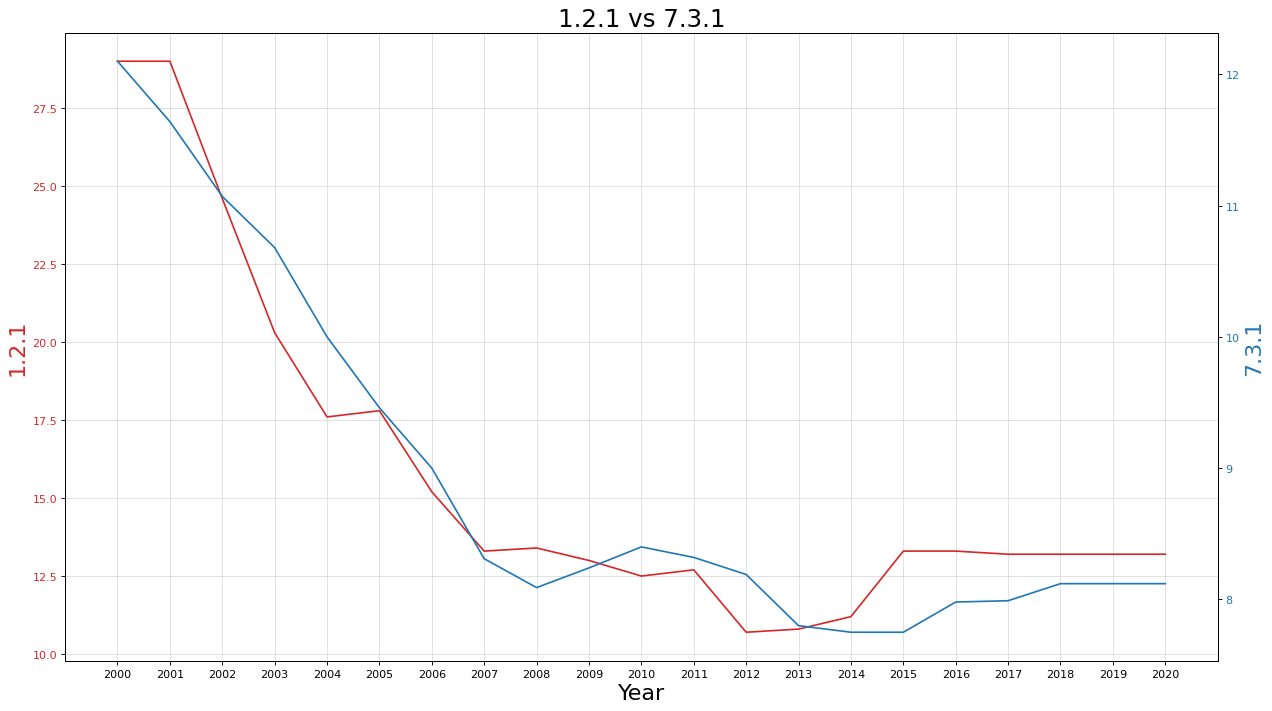

In [34]:
grafik()

##**Реестр прогноза показателей по нищите, голоду, качестве образования, достойной работе и экономического роста на 2021г.**

In [35]:
file_pred

,Indicator,predict,MSE
0,1.1.1,-0.0148,0.0007
1,1.2.1,10.4743,0.0003
2,1.5.2,398521696.0000,0.0678
3,1.a.2,10.8492,0.0198
4,2.1.1,2.5117,0.0025
5,2.1.2,4.3585,0.6965
6,2.2.1,-0.0148,0.0007
7,2.2.2,-0.0148,0.0007
8,2.5.2,37.2430,0.0393
9,4.1.1,94.7760,0.2884


***Для обучения модели прогноза показателей ЦУР, данных по России было недостаточно.
Поэтому с сайта ООН были скачаны показатели ЦУР по другим странам, экономика которых
наиболее зависит от полезных ископаемых: Австралия, Канада, Норвегия.
 Была обучена модель одномерной сверточной нейронной сети на данных каждой страны 
 последовательно.
 По обученной модели на данных по России был сделан прогноз по показателям ЦУР по
 нищете, голоду, качеству образования, достойной работе и экономическому росту. В реестре представлен индикатор показателей ЦУР, предсказанные значения по этим показателям predict и cреднеквадратичная ошибка MSE***

###**Для улучшения результатов данной работы можно:**
1. увеличить автоматизацию обработки данных
2. увеличить количество стран для обучения модели
3. подобрать другую модель
4. оптимизировать гиперпараметры модели 


